In [1]:
import random
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import AdamW, get_scheduler
from sacrebleu.metrics import BLEU
from tqdm.auto import tqdm
import json

def seed_everything(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
seed_everything(42)

max_input_length = 256
max_target_length = 32

batch_size = 16


class DuReaderQG(Dataset):
    def __init__(self, data_file):
        self.data = self.load_data(data_file)

    def load_data(self, data_file):
        Data = {}
        with open(data_file, 'r', encoding='utf-8') as f:
            idx = 0
            for line in f:  # Read line by line
                try:
                    article = json.loads(line.strip())
                    context = article.get('context', '')
                    question = article.get('question', '')
                    answer = article.get('answer', '')
                    q_id = article.get('id', idx)

                    Data[idx] = {
                        'id': q_id,
                        'context': context,
                        'question': question,
                        'answer': answer,
                    }
                    idx += 1
                except json.JSONDecodeError as e:
                    print(f"Skipping invalid JSON line: {line}\nError: {e}")
        return Data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# Instantiate dataset (assuming JSON Lines format)
train_data = DuReaderQG('data/DuReaderQG/train.json')
valid_data = DuReaderQG('data/DuReaderQG/dev.json')
test_data = valid_data

## define model and tokenizer:


tokenizer = AutoTokenizer.from_pretrained('uer/t5-small-chinese-cluecorpussmall')
model = AutoModelForSeq2SeqLM.from_pretrained('uer/t5-small-chinese-cluecorpussmall').to(device)

def collate_fn(batch_samples):
    input_questions, input_contexts, batch_targets = [], [], []

    for sample in batch_samples:
        input_questions.append(f"问题：{sample['question']}{tokenizer.sep_token}原文：{sample['context']}")
        input_contexts.append(f"")
        batch_targets.append(f"答案：{sample['answer']}{tokenizer.eos_token}")

    batch_data = tokenizer(
        input_questions,
        input_contexts,
        padding=True,
        max_length=max_input_length,
        truncation=True,
        return_tensors="pt",

    )

    labels = tokenizer(
        batch_targets,
        padding=True,
        max_length=max_target_length,
        truncation=True,
        return_tensors="pt",
    )["input_ids"]

    labels[labels == 0] = -100

    batch_data["labels"] = labels
    batch_data.pop("token_type_ids", None)  # Safe re/moval

    return batch_data

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Using cuda device


In [2]:
inputs = next(iter(train_dataloader)).to(device)

In [3]:
model(**inputs)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Seq2SeqLMOutput(loss=tensor(9.3608, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[[-0.5468, -0.5647, -0.5629,  ..., -0.5844, -0.5672, -0.5774],
         [-0.5468, -0.5647, -0.5629,  ..., -0.5844, -0.5672, -0.5774],
         [-0.1454, -0.3497, -0.3462,  ..., -0.3487, -0.3470, -0.3472],
         ...,
         [-0.0770, -0.3896, -0.3890,  ..., -0.3919, -0.3885, -0.3885],
         [-0.0520, -0.3956, -0.3963,  ..., -0.3998, -0.3963, -0.3965],
         [-0.0688, -0.4055, -0.4067,  ..., -0.4105, -0.4064, -0.4071]],

        [[-0.5441, -0.5640, -0.5624,  ..., -0.5837, -0.5664, -0.5766],
         [-0.5441, -0.5640, -0.5624,  ..., -0.5837, -0.5664, -0.5766],
         [-0.1357, -0.3153, -0.3135,  ..., -0.3137, -0.3125, -0.3121],
         ...,
         [-0.0915, -0.3834, -0.3852,  ..., -0.3874, -0.3831, -0.3837],
         [-0.0772, -0.3888, -0.3896,  ..., -0.3939, -0.3886, -0.3901],
         [-0.0814, -0.3749, -0.3744,  ..., -0.3784, -0.3738, -0.3748]],

        [[-0.5428, -0.5622,

In [4]:
# define train loop and test loop:
def train_loop(dataloader, model, optimizer, lr_scheduler, epoch, total_loss):
    progress_bar = tqdm(range(len(dataloader)))
    progress_bar.set_description(f'loss: {0:>7f}')
    finish_batch_num = (epoch-1) * len(dataloader)

    loss_list = []
    model.train()
    for batch, batch_data in enumerate(dataloader, start=1):
        batch_data = batch_data.to(device)
        outputs = model(**batch_data)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        loss_list.append(loss.item())
        total_loss += loss.item()
        progress_bar.set_description(f'loss: {total_loss/(finish_batch_num + batch):>7f}')
        progress_bar.update(1)
    return total_loss, loss_list

In [5]:
# define test loop
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
def test_loop(dataloader, model, mode='Test'):
    assert mode in ['Valid', 'Test']
    preds, labels = [], []
    bleu_1_scores, bleu_2_scores, bleu_3_scores, bleu_4_scores = [], [], [], []

    smoothie = SmoothingFunction().method4

    model.eval()
    for batch_data in tqdm(dataloader):
        batch_data = {key: val.to(device) for key, val in batch_data.items()}
        with torch.no_grad():
            generated_tokens = model.generate(
                batch_data["input_ids"],
                attention_mask=batch_data["attention_mask"],
                max_length=max_target_length,
            ).cpu().numpy()

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(
            np.where(batch_data["labels"].cpu().numpy() != -100,
                     batch_data["labels"].cpu().numpy(),
                     tokenizer.pad_token_id),
            skip_special_tokens=True
        )

        preds += [pred.strip() for pred in decoded_preds]
        labels += [[label.strip()] for label in decoded_labels]

        for pred, ref in zip(decoded_preds, decoded_labels):
            bleu_1_scores.append(sentence_bleu([ref.split()], pred.split(), weights=(1, 0, 0, 0), smoothing_function=smoothie))
            bleu_2_scores.append(sentence_bleu([ref.split()], pred.split(), weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie))
            bleu_3_scores.append(sentence_bleu([ref.split()], pred.split(), weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie))
            bleu_4_scores.append(sentence_bleu([ref.split()], pred.split(), weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie))

    return np.mean(bleu_1_scores), np.mean(bleu_2_scores), np.mean(bleu_3_scores), np.mean(bleu_4_scores)


In [40]:
test_loop(test_dataloader, model)

  0%|          | 0/31 [00:00<?, ?it/s]

(0.0, 0.0, 0.0, 0.0)

In [6]:
# define optimizer:
learning_rate = 5e-5
epoch_num = 20

optimizer = AdamW(model.parameters(), lr=learning_rate)
num_training_steps = epoch_num * len(train_dataloader)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=int(num_training_steps * 0.1),
    num_training_steps=epoch_num*len(train_dataloader),
)


total_loss = 0.
best_bleu4 = 0.
loss_list = []

# main loop:
for t in range(epoch_num):
    print(f"Epoch {t+1}/{epoch_num}\n-------------------------------")
    total_loss, epoch_loss_list = train_loop(train_dataloader, model, optimizer, lr_scheduler, t+1, total_loss)
    loss_list.extend(epoch_loss_list)
    bleu1, bleu2, bleu3, bleu4 = test_loop(valid_dataloader, model)
    print(f"BLEU-1: {bleu1:.4f} | BLEU-2: {bleu2:.4f} | BLEU-3: {bleu3:.4f} | BLEU-4: {bleu4:.4f}\n")
    if bleu4 > best_bleu4:
        best_bleu4 = bleu4
        print('saving new weights...\n')
        torch.save(
            model.state_dict(),
            f'T5QA_epoch_{t+1}_valid_bleu_{bleu4:0.2f}_model_weights.bin'
        )
print("Done!")

Epoch 1/20
-------------------------------


D:\anaconda\envs\d2l\lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.0191 | BLEU-2: 0.0162 | BLEU-3: 0.0094 | BLEU-4: 0.0059

saving new weights...

Epoch 2/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.0632 | BLEU-2: 0.0533 | BLEU-3: 0.0322 | BLEU-4: 0.0212

saving new weights...

Epoch 3/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.3166 | BLEU-2: 0.3004 | BLEU-3: 0.2823 | BLEU-4: 0.2041

saving new weights...

Epoch 4/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.0000 | BLEU-2: 0.0000 | BLEU-3: 0.0000 | BLEU-4: 0.0000

Epoch 5/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.0000 | BLEU-2: 0.0000 | BLEU-3: 0.0000 | BLEU-4: 0.0000

Epoch 6/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.5733 | BLEU-2: 0.5435 | BLEU-3: 0.5109 | BLEU-4: 0.4242

saving new weights...

Epoch 7/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.6491 | BLEU-2: 0.6154 | BLEU-3: 0.5780 | BLEU-4: 0.4933

saving new weights...

Epoch 8/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.6821 | BLEU-2: 0.6500 | BLEU-3: 0.6149 | BLEU-4: 0.5311

saving new weights...

Epoch 9/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.6789 | BLEU-2: 0.6488 | BLEU-3: 0.6157 | BLEU-4: 0.5340

saving new weights...

Epoch 10/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.6937 | BLEU-2: 0.6631 | BLEU-3: 0.6295 | BLEU-4: 0.5493

saving new weights...

Epoch 11/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.6971 | BLEU-2: 0.6663 | BLEU-3: 0.6322 | BLEU-4: 0.5528

saving new weights...

Epoch 12/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.6981 | BLEU-2: 0.6676 | BLEU-3: 0.6340 | BLEU-4: 0.5532

saving new weights...

Epoch 13/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.7036 | BLEU-2: 0.6732 | BLEU-3: 0.6393 | BLEU-4: 0.5579

saving new weights...

Epoch 14/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.7006 | BLEU-2: 0.6707 | BLEU-3: 0.6373 | BLEU-4: 0.5603

saving new weights...

Epoch 15/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.7106 | BLEU-2: 0.6805 | BLEU-3: 0.6467 | BLEU-4: 0.5684

saving new weights...

Epoch 16/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.6933 | BLEU-2: 0.6640 | BLEU-3: 0.6315 | BLEU-4: 0.5533

Epoch 17/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.7015 | BLEU-2: 0.6721 | BLEU-3: 0.6396 | BLEU-4: 0.5615

Epoch 18/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.7058 | BLEU-2: 0.6758 | BLEU-3: 0.6421 | BLEU-4: 0.5653

Epoch 19/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.7057 | BLEU-2: 0.6757 | BLEU-3: 0.6420 | BLEU-4: 0.5648

Epoch 20/20
-------------------------------


  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

BLEU-1: 0.6899 | BLEU-2: 0.6603 | BLEU-3: 0.6271 | BLEU-4: 0.5515

Done!


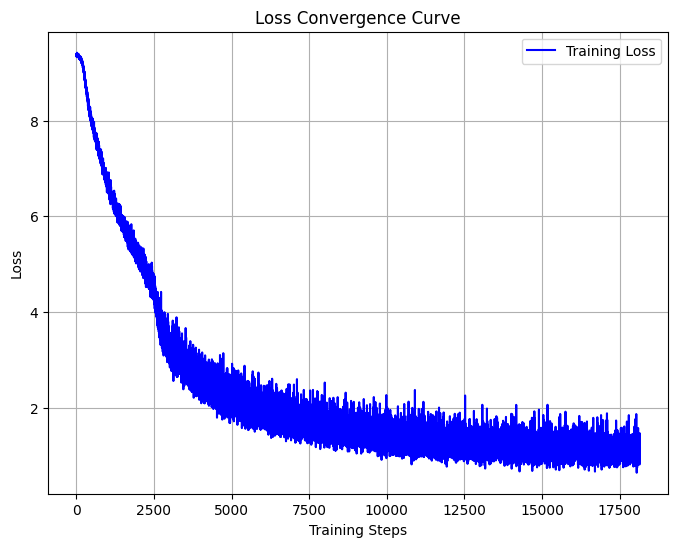

In [9]:
import matplotlib.pyplot as plt

def plot_loss(loss_list):
    plt.figure(figsize=(8, 6))
    plt.plot(loss_list, label="Training Loss", color="blue")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Loss Convergence Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_curve.png")  # ✅ Save figure
    plt.show()

plot_loss(loss_list)  # ✅ Plot loss curve

In [10]:
generated_tokens = model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], max_length=max_target_length,).cpu().numpy()
label_tokens = inputs["labels"].cpu().numpy()
decoded_inputs = tokenizer.batch_decode(inputs["input_ids"], skip_special_tokens=True)
decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
label_tokens = np.where(label_tokens != -100, label_tokens, tokenizer.pad_token_id)
decoded_labels = tokenizer.batch_decode(label_tokens, skip_special_tokens=True)

In [11]:
decoded_labels

['答 案 ： 工 商 管 理 类',
 '答 案 ： 太 原 解 放 军 264 医 院',
 '答 案 ： 9 月 份 到 11 月 份',
 '答 案 ： 至 少 280 个 蛋',
 '答 案 ： 答',
 '答 案 ： 12 小 时',
 '答 案 ：',
 '答 案 ： 700 到 800 毫 升 左 右',
 '答 案 ： 左 右',
 '答 案 ： 鱼',
 '答 案 ： 影',
 '答 案 ： 9 个',
 '答 案 ： 四 肢 多 关 节 肿 痛',
 '答 案 ： 北 京 大 学 第 一 医 院',
 '答 案 ： 西 格 蒙',
 '答 案 ： 1600 公 里 左 右']

In [12]:
decoded_preds

['答 案 ： 工 商 管 理 类',
 '答 案 ： 太 原 解 放 军 264 医 院',
 '答 案 ： 9 月 份 到 11 月 份',
 '答 案 ： 280 个',
 '答 案 ： 答 案 ： 节 寰',
 '答 案 ： 3 个 小 时',
 '答 案 ：',
 '答 案 ： 30 克 左 右',
 '答 案 ： 左 右',
 '答 案 ： 鱼',
 '答 案 ： 影',
 '答 案 ： 9 个',
 '答 案 ： 类 风 湿 关 节 炎',
 '答 案 ： 青 岛 第 一 医 院',
 '答 案 ： 西 格 蒙',
 '答 案 ： 1600 公 里 左 右']

In [13]:
decoded_inputs

['问 题 ： 人 力 资 源 管 理 专 业 属 于 什 么 类 原 文 ： 人 力 资 源 管 理 专 业 学 科 ： 管 理 学 ( ) 门 类 ： 工 商 管 理 类 ( of ) 专 业 名 称 ： 人 力 资 源 管 理 ( ) 业 务 培 养 目 标 ： 本 专 业 培 养 具 备 管 理 、 经 济 、 法 律 及 人 力 资 源 管 理 等 方 面 的 知 识 和 能 力 ， 能 在 事 业 单 位 及 政 府 部 门 从 事 人 力 资 源 管 理 以 及 教 学 、 科 研 方 面 工 作 的 工 商 管 理 学 科 高 级 专 门 人 才 。 业 务 培 养 要 求 ： 本 专 业 学 生 上 要 学 习 管 理 学 、 经 济 学 及 人 力 资 源 管 理 方 面 的 基 本 理 论 和 基 本 知 识 ， 受 到 人 力 资 源 管 理 方 法 与 技 巧 方 面 的 基 本 训 练 ， 具 有 分 析 和 解 决 人 力 资 源 管 理 问 题 的 基 本 能 力 。 毕 业 生 应 获 得 以 下 几 方 面 的 知 识 和 能 力 ：',
 '问 题 ： 耳 鸣 医 院 原 文 ： 太 原 解 放 军 264 医 院 采 用 国 际 权 威 认 证 的 、 堪 称 目 前 治 疗 耳 鸣 耳 聋 的 最 佳 技 术 - - 三 联 一 体 疗 法 。 一 、 声 信 息 治 疗 仪 ： 是 在 深 入 研 究 中 国 传 统 医 学 五 音 入 五 脏 理 论 基 础 上 ， 结 合 现 代 声 学 与 人 体 生 理 研 究, 根 据 中 西 医 结 合 的 方 法 ， 辨 证 与 辨 病 相 结 合 的 原 则 ， 利 用 量 化 的 声 音 对 人 体 听 觉 系 统 直 接 刺 激 和 调 节 作 用 、 对 中 枢 神 经 和 植 物 神 经 系 统 产 生 的 一 系 列 生 理 效 应 ， 直 接 声 至 病 所 对 治 疗 各 种 耳 聋 、 耳 鸣 、 眩 晕 、 血 管 性 头 痛 、 失 眠 、 幻 觉 、 幻 听 等 听 觉 系 统 和 神 经 系 统 疾 病 的 一 种 新 型 医 疗 设 备 。 该 仪 器 根 据 个 体 生 理 指 标 ， 利 用 量 化 的 声 音 治 疗 ，',
 '问 题 ： 